In [1]:
%reset

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
import pandas as pd
import pickle
import copy
import pandas as pd
from tqdm.notebook import tqdm_notebook
import os

In [3]:
epochs_dir = 'C:\AnatArzData\YKM_data\epochs_and_evoked_allSubs'
prepro_name = "referenced"
import_type = "5Electorodes_plainEEGLAB"
file_types = ['wake','sleep']

In [4]:
all_subjects = np.array(
    ['08', '09', '10','11', '12','13', '14', '15', '16','17', '19', '20', '21', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34','35', '36', '37', '38'])
outlier_subs_major_exp_fault = ['12','18','22']
valid_subs = np.delete(all_subjects,np.isin(all_subjects,outlier_subs_major_exp_fault))
subs = valid_subs

cfg = {}
cfg['outputs_dir_path'] = 'C:\AnatArzData\YKM_data\outputs'
cfg['epochs_dir'] = 'C:\AnatArzData\YKM_data\epochs_and_evoked_allSubs'
cfg['set_files_dir'] =  'C:\\AnatArzData\\Data\\reref'

cfg['prepro_name'] = prepro_name
cfg['sleep_states_eeglab'] = np.asarray(['N1','N2','N3','Rt','Rp'])
cfg['sleep_states'] =  np.asarray(['N2','N3','REM'])
cfg['wake_states'] = np.asarray(['Wn'])
cfg['vigi_states'] = np.concatenate([cfg['wake_states'],cfg['sleep_states']])
cfg['vigi_states_eeglab'] =np.concatenate([cfg['wake_states'],cfg['sleep_states_eeglab']])
cfg['TOA'] = np.asarray(['T','O','A'])
cfg['electrodes'] = np.asarray([4,5,10,79,84]) # In MATLAB they are [5,6,11,80,85]
cfg['ch_names'] = np.asarray(['E6','E7','E13','E106','E112'])
cfg['samples_per_epoch'] = 138
cfg['toneHeights'] = np.asarray(['650','845','1098','1428','1856','2413','3137','4079','5302'])
cfg['trialPositions'] = np.asarray(['0','1','2','3','4','5','6','7','8','9'])
cfg['subs'] = valid_subs
cfg['outlier_subs'] = outlier_subs_major_exp_fault
cfg['times'] = np.arange(-100,452,4)
cfg['sample_freq'] = 250

fig_output_dir = f"{cfg['outputs_dir_path']}/import"
if not os.path.exists(fig_output_dir):
    os.mkdir(fig_output_dir)

In [5]:
freq_bands = {}
# freq_bands['Delta'] = {}
# freq_bands['Delta']['min'] = 0
# freq_bands['Delta']['max'] = 4
# freq_bands['Delta']['title'] = f"Delta ({freq_bands['Delta']['min']}-{freq_bands['Delta']['max']} Hz)"

freq_bands['Theta'] = {}
freq_bands['Theta']['min'] = 4
freq_bands['Theta']['max'] = 8
freq_bands['Theta']['title'] = f"Theta ({freq_bands['Theta']['min']}-{freq_bands['Theta']['max']} Hz)"

freq_bands['Alpha'] = {}
freq_bands['Alpha']['min'] = 8
freq_bands['Alpha']['max'] = 12
freq_bands['Alpha']['title'] = f"Alpha ({freq_bands['Alpha']['min']}-{freq_bands['Alpha']['max']} Hz)"

freq_bands['Beta'] = {}
freq_bands['Beta']['min'] = 12
freq_bands['Beta']['max'] = 30
freq_bands['Beta']['title'] = f"Beta ({freq_bands['Beta']['min']}-{freq_bands['Beta']['max']} Hz)"

freq_bands['Gamma'] = {}
freq_bands['Gamma']['min'] = 30
freq_bands['Gamma']['max'] = 45
freq_bands['Gamma']['title'] = f"Gamma ({freq_bands['Gamma']['min']}-{freq_bands['Gamma']['max']} Hz)"

cfg['freq_bands'] = freq_bands

In [6]:
# get the columns for the conditions table
numOfRows = len(subs) * len(cfg['sleep_states_eeglab']) * len(cfg['toneHeights'] ) * len(cfg['TOA'] ) * len(cfg['trialPositions'])
allEvents_arr = np.zeros((numOfRows, 8), dtype=object)
allEpochs_perCond = {}
curr_row_num = 0
event_str =''

# populate table and with subject's conditions metadata and create an eeg data dictionary with condition as key
for sub in tqdm_notebook(subs):
    #print(f'Importing sub: {sub}')
    ## upload subject's files
    sub_load_filepath = f'{epochs_dir}\\epochs_sub{sub}_{prepro_name}_{import_type}.mat'
    try: matlabImport = scipy.io.loadmat(sub_load_filepath, simplify_cells=True)
    except Exception: print(f'Error importing sub file at: {sub_load_filepath}')

    for file_type in file_types:
        events_eeglabStruct = matlabImport[f'subEvents_{file_type}']
        events_eeglab_df = pd.DataFrame(events_eeglabStruct)
        epochs_eeglabStruct =  matlabImport[f'subAllEpochs_{file_type}']

        if file_type == 'sleep':
            curr_file_vg_states_eeglab = cfg['sleep_states']
        elif file_type == 'wake':
            curr_file_vg_states_eeglab =  cfg['wake_states']

        for vg_i, curr_vg in enumerate(curr_file_vg_states_eeglab):
            for toneTy_i, curr_toneTy in enumerate(cfg['TOA'] ):
                for toneHi_i, curr_toneHi in enumerate(cfg['toneHeights'] ):
                    for trialPos_i, curr_trialPos in enumerate(cfg['trialPositions']):
                        if      curr_vg == 'Wn': curr_vg_eeglabaname = ''
                        else:   curr_vg_eeglabaname = curr_vg

                        if curr_vg == 'REM':
                            event_str1 = f"{'Rp'}{curr_toneTy}{curr_toneHi}_{curr_trialPos}"
                            event_str2 = f"{'Rt'}{curr_toneTy}{curr_toneHi}_{curr_trialPos}"
                            curr_event_df = events_eeglab_df[(events_eeglab_df['type'] == event_str1) | (events_eeglab_df['type'] == event_str2)]
                        else:
                            event_str = f"{curr_vg_eeglabaname}{curr_toneTy}{curr_toneHi}_{curr_trialPos}"
                            curr_event_df = events_eeglab_df[(events_eeglab_df['type'] == event_str)]

                        curr_event_epochs_eeglab_ids = np.asarray(curr_event_df['epoch'])

                        ## handles WnT1428_4,WnT1428_3 issue by taking every first WnT1428_3 event only
                        if event_str == 'T1428_3':
                            i = 0
                            while i<len(curr_event_epochs_eeglab_ids)-1:
                                if curr_event_epochs_eeglab_ids[i] == curr_event_epochs_eeglab_ids[i+1]-1:
                                    curr_event_epochs_eeglab_ids = np.delete(curr_event_epochs_eeglab_ids,i+1)
                                else:
                                    i+=1

                        sample_in_cond = len(curr_event_epochs_eeglab_ids)
                        if sample_in_cond > 0:
                            allEpochs_perCond[f"{curr_row_num}"] = epochs_eeglabStruct[:,:,curr_event_epochs_eeglab_ids - 1]  ## matlab start counting from 1
                        allEvents_arr[curr_row_num, :] = [curr_row_num, sub, curr_vg, curr_toneTy, curr_toneHi, curr_trialPos, sample_in_cond,curr_event_epochs_eeglab_ids]

                        curr_row_num += 1

  0%|          | 0/28 [00:00<?, ?it/s]

In [7]:
allEvents_df = pd.DataFrame(allEvents_arr, columns=['Cond_id', 'Subject', 'Vigilance', 'TOA', 'ToneHeight', 'TrialPosition', 'SamplesCount','Epoch_eeglab_ids'])
allEvents_df = allEvents_df[allEvents_df.Subject != 0]
allEvents_df

,Cond_id,Subject,Vigilance,TOA,ToneHeight,TrialPosition,SamplesCount,Epoch_eeglab_ids
0,0,08,Wn,T,650,0,24,"[142, 262, 422, 682, 942, 1062, 1262, 1582, 16..."
1,1,08,Wn,T,650,1,24,"[144, 264, 424, 684, 944, 1064, 1264, 1584, 16..."
2,2,08,Wn,T,650,2,24,"[146, 266, 426, 686, 946, 1066, 1266, 1586, 16..."
3,3,08,Wn,T,650,3,24,"[148, 268, 428, 688, 948, 1068, 1268, 1588, 16..."
4,4,08,Wn,T,650,4,24,"[150, 270, 430, 690, 950, 1070, 1270, 1590, 16..."
...,...,...,...,...,...,...,...,...
30235,30235,38,REM,A,5302,5,0,[]
30236,30236,38,REM,A,5302,6,0,[]
30237,30237,38,REM,A,5302,7,0,[]
30238,30238,38,REM,A,5302,8,0,[]


In [8]:
## add auxiliary column
def TOA_type(row):
    if row['TOA'] == 'O' and (row['TrialPosition'] == '5' or row['TrialPosition'] == '6' or row['TrialPosition'] == '7' or row['TrialPosition'] == '8'):
        return 'Rand'
    elif row['TOA'] == 'O' and row['TrialPosition']=='9':
        return 'Fixed'
    else:
        return row['TOA']
allEvents_df['TOA_cond'] = allEvents_df.apply(lambda row: TOA_type(row), axis=1)
allEvents_df

,Cond_id,Subject,Vigilance,TOA,ToneHeight,TrialPosition,SamplesCount,Epoch_eeglab_ids,TOA_cond
0,0,08,Wn,T,650,0,24,"[142, 262, 422, 682, 942, 1062, 1262, 1582, 16...",T
1,1,08,Wn,T,650,1,24,"[144, 264, 424, 684, 944, 1064, 1264, 1584, 16...",T
2,2,08,Wn,T,650,2,24,"[146, 266, 426, 686, 946, 1066, 1266, 1586, 16...",T
3,3,08,Wn,T,650,3,24,"[148, 268, 428, 688, 948, 1068, 1268, 1588, 16...",T
4,4,08,Wn,T,650,4,24,"[150, 270, 430, 690, 950, 1070, 1270, 1590, 16...",T
...,...,...,...,...,...,...,...,...,...
30235,30235,38,REM,A,5302,5,0,[],A
30236,30236,38,REM,A,5302,6,0,[],A
30237,30237,38,REM,A,5302,7,0,[],A
30238,30238,38,REM,A,5302,8,0,[],A


In [9]:
# output: [#conds, #elect, #times]
def getEpochsPerConstraint(constraints):
    curr_df =allEvents_df.copy(deep=True)
    # apply constraints
    for key in constraints: curr_df = curr_df[(curr_df[key] == constraints[key])]

    curr_df = curr_df[(curr_df.SamplesCount > 0)] # discard cond with 0 enough samples
    epochsPerCond = {}
    for key in curr_df.Cond_id:
        epochsPerCond[str(key)] = allEpochs_perCond[str(key)]

    ## load the metadata first and them the data. More time efficient
    epochs_name_in_const = []
    epochs_trial_num_per_cond = []
    for cond in epochsPerCond:
        for curr_cond_trial in range( epochsPerCond[cond].shape[2]):
            if len(epochs_name_in_const)==0:
                epochs_name_in_const =[cond]
                epochs_trial_num_per_cond =[curr_cond_trial]
            else:
                epochs_name_in_const = np.append(epochs_name_in_const,cond)
                epochs_trial_num_per_cond = np.append(epochs_trial_num_per_cond,curr_cond_trial)

    epochs_in_const = np.zeros((len(epochs_name_in_const),len(cfg['electrodes']),len(cfg['times'])))
    trial = 0
    for cond in epochsPerCond:
        for curr_cond_trial in range( epochsPerCond[cond].shape[2]):
            epochs_in_const[trial,:,:] = epochsPerCond[cond][:,:,curr_cond_trial]
            trial+=1

    return epochs_in_const, epochs_name_in_const, epochs_trial_num_per_cond

In [10]:
#### Remove outlier trials
# outlier trials are trials which have a time-point with a value which exceeds (thresh*std)s from the subject's time-point at his mean erp
toa_cond_arr = ['T','Rand','Fixed']
trial_outliers_numOfRows = len(subs) * len(toa_cond_arr) * len(cfg['vigi_states'])
trial_outliers_arr = np.zeros((trial_outliers_numOfRows, 6), dtype=object)

const={}
allEpochs_perCond_trialFilt =copy.deepcopy(allEpochs_perCond)
allEvents_df_trialFilt = allEvents_df.copy(deep=True)
std_thresh = 3.5
subs_reg_trials_perc = np.zeros(len(cfg['subs']))
curr_row_num = 0
for sub_i,sub in tqdm_notebook(enumerate(cfg['subs'])):
    sub_rej_trials = 0
    sub_trials = 0
    for vigi in cfg['vigi_states']:
        ## get the mean and std of the current sub
        const= {'Subject': sub, 'Vigilance': vigi}
        epochs_in_const, epochs_name_in_const,epochs_trial_num_per_cond = getEpochsPerConstraint(const)
        mean_sub = np.nanmean(epochs_in_const, axis=0)
        std_sub = np.nanstd(epochs_in_const, axis=0)
        min_allowed_trial = mean_sub - (std_thresh * std_sub)
        max_allowed_trial = mean_sub + (std_thresh * std_sub)
        for curr_toa_Cond in toa_cond_arr:
            subVigiTOA_rej_trials = 0
            subVigiTOA_trials = 0
            currSub_allEvents = allEvents_df[(allEvents_df["Subject"]== sub) & (allEvents_df["Vigilance"]== vigi) & (allEvents_df["TOA_cond"]== curr_toa_Cond)]
            ## create df and epochs_dict with removed outliers
            for cond in currSub_allEvents.Cond_id:
                if str(cond) not in allEpochs_perCond: continue
                bad_trials = []
                number_of_trials = allEpochs_perCond[str(cond)].shape[2]
                sub_trials+=number_of_trials
                for trial_i in range(number_of_trials):
                    currTrial_goodElectrCount = len(cfg['electrodes'])

                    for electrode_i in range(len(cfg['electrodes'])):
                        curr_trial = allEpochs_perCond[str(cond)][electrode_i,:,trial_i]
                        if np.any(np.less(curr_trial,min_allowed_trial[electrode_i,:])) or np.any(np.greater(curr_trial,max_allowed_trial[electrode_i,:])):
                            currTrial_goodElectrCount -= 1
                    if currTrial_goodElectrCount < len(cfg['electrodes']):
                        bad_trials = np.append(bad_trials,trial_i)
                if len(bad_trials)!=0:
                    sub_rej_trials +=len(bad_trials)
                    allEpochs_perCond_trialFilt[str(cond)] = np.delete(allEpochs_perCond_trialFilt[str(cond)],bad_trials.astype(int),2)
                allEvents_df_trialFilt.loc[allEvents_df_trialFilt.Cond_id == int(cond), "SamplesCount"] = number_of_trials - len(bad_trials)

                subVigiTOA_rej_trials+=len(bad_trials)
                subVigiTOA_trials+=number_of_trials

            trial_outliers_arr[curr_row_num, :] = [sub, vigi, curr_toa_Cond,subVigiTOA_trials, subVigiTOA_rej_trials, subVigiTOA_rej_trials/subVigiTOA_trials ]
            curr_row_num+=1

    # subs_reg_trials_perc[sub_i] =  sub_rej_trials / sub_trials
    # print(f'sub:{sub}, reg_trials_perc{subs_reg_trials_perc[sub_i]}')


0it [00:00, ?it/s]

In [11]:
trial_outliers_df = pd.DataFrame(trial_outliers_arr, columns=['Subject', 'Vigilance', 'TOA', '#samples','#badSamples','badSamplesRatio'])
trial_outliers_df.to_excel(f'{fig_output_dir}\\trialExclusion_Rule-oneOrMoreAreBad_stdThresh-{std_thresh}.xlsx')
trial_outliers_df

,Subject,Vigilance,TOA,#samples,#badSamples,badSamplesRatio
0,08,Wn,T,1920,236,0.122917
1,08,Wn,Rand,108,12,0.111111
2,08,Wn,Fixed,108,13,0.12037
3,08,N2,T,5310,660,0.124294
4,08,N2,Rand,293,21,0.071672
...,...,...,...,...,...,...
331,38,N3,Rand,58,4,0.068966
332,38,N3,Fixed,84,6,0.071429
333,38,REM,T,1633,125,0.076546
334,38,REM,Rand,90,8,0.088889


## Save

In [12]:
with open(f'{epochs_dir}\\{import_type}.pkl', 'wb') as file:
    pickle.dump([allEvents_df, allEpochs_perCond,cfg], file)

with open(f'{epochs_dir}\\{import_type}_excOulierTrials-{std_thresh}.pkl', 'wb') as file:
    pickle.dump([allEvents_df_trialFilt, allEpochs_perCond_trialFilt,cfg], file)

# Load
# with open(f'{epochs_dir}\\{import_type}_allEvents_df.pkl', 'rb') as file:
#     _allEvents_df = pickle.load(file)
# with open(f'{epochs_dir}\\{import_type}_allEpochs.pkl', 'rb') as file:
#     _allEpochs_perCond = pickle.load(file)

# Tests

NOTICE: It seems that all the events WnT1428_4 are encoded WnT1428_3.
Such that WnT1428_4 have 0 samples and WnT1428_3 double the normal


In [13]:
allEvents_df[(allEvents_df["ToneHeight"]=='1428') &
             (allEvents_df["Vigilance"]=='Wn')&
             (allEvents_df["TOA"]=='T')&
             (allEvents_df["TrialPosition"]=='4')
            ]

# allEvents_df[(allEvents_df["ToneHeight"]=='1428') &
#              (allEvents_df["Vigilance"]=='Wn')&
#              (allEvents_df["TOA"]=='T')&
#              (allEvents_df["TrialPosition"]=='3')
#              ]

,Cond_id,Subject,Vigilance,TOA,ToneHeight,TrialPosition,SamplesCount,Epoch_eeglab_ids,TOA_cond
34,34,08,Wn,T,1428,4,0,[],T
1114,1114,09,Wn,T,1428,4,0,[],T
2194,2194,10,Wn,T,1428,4,0,[],T
3274,3274,11,Wn,T,1428,4,0,[],T
4354,4354,13,Wn,T,1428,4,0,[],T
5434,5434,14,Wn,T,1428,4,0,[],T
6514,6514,15,Wn,T,1428,4,0,[],T
7594,7594,16,Wn,T,1428,4,0,[],T
8674,8674,17,Wn,T,1428,4,0,[],T
9754,9754,19,Wn,T,1428,4,0,[],T


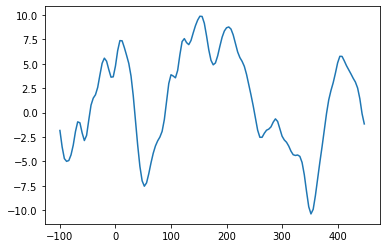

In [14]:
# test whether creating df and data matrix distorts the data
epochs_ids = ['2','3','4','10','11','12','13','14','20','21','22','23']
sum_arr = np.mean(allEpochs_perCond['1'],axis=(0,2))
for epochs_id in epochs_ids:
    add_arr = np.mean(allEpochs_perCond[epochs_id],axis=(0,2))
    sum_arr = np.sum((sum_arr,add_arr), axis=0)
plt.plot(cfg['times'],sum_arr)
plt.show()

In [15]:
## test whether scipy.io.loadmat "simplify_cells=True" is distorting the data
## test individual epochs
sub_load_filepath = f'{epochs_dir}\\epochs_sub32_{prepro_name}_{import_type}.mat'
try: matlabImport = scipy.io.loadmat(sub_load_filepath, simplify_cells=True)
except Exception: print(f'Error importing sub file at: {sub_load_filepath}')
epochs_import =  matlabImport['subAllEpochs_wake'] # #elecrd, #times, #epochs

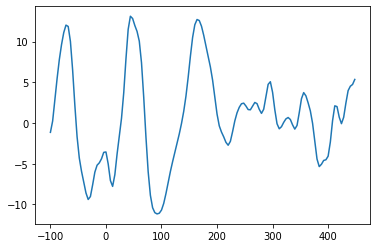

In [16]:
arr = epochs_import[0,:,1674]
plt.plot(cfg['times'],arr)

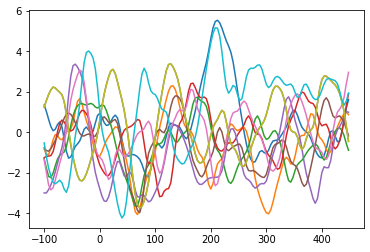

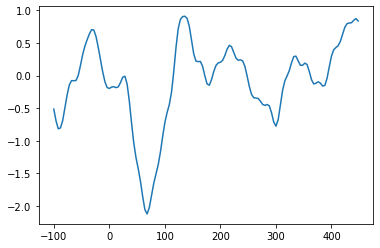

In [17]:
#### Test a whole condition (in this case: 32, Wn, T5302_)
c_1 = [42,282,561,641,960,1140,1297,1455,1669,1880,2118,2214,2543,2621,2790,3103,3143,3401,3641,4118,4218,4335,4555];
c_2 = [44,284,563,643,962,1142,1299,1457,1671,1882,2120,2216,2545,2622,2792,3105,3145,3403,3643,3841,4120,4220,4337,4557];
c_3 = [46,285,565,645,964,1144,1301,1459,1673,1884,2122,2218,2547,2624,3107,3147,3405,3645,3843,4122,4222,4339,4559];
c_4 = [48,287,567,647,966,1146,1303,1461,1675,1886,2124,2220,2549,2795,3109,3149,3407,3647,3845,4124,4224,4341,4561];
c_5 = [50,289,569,649,968,1148,1305,1463,1677,1888,2126,2222,2550,2627,2797,3111,3151,3409,3649,3847,4126,4226,4343,4563];
c_6 = [52,291,571,651,970,1150,1307,1465,1679,1890,2128,2224,2552,2629,2799,3113,3153,3651,3849,4128,4345,4565];
c_7 = [54,293,573,653,972,1152,1309,1467,1681,1892,2130,2226,2554,2631,2801,3115,3413,3653,3851,4130,4229,4567];
c_8 = [56,295,575,655,974,1154,1311,1683,2132,2228,2556,2633,2803,3117,3157,3415,3655,3853,4132,4231,4349];
c_9 = [58,297,577,657,1313,1471,1685,1896,2558,2635,2805,3119,3159,3417,3657,4134,4233,4351,4571];
c_10 = [978,1158,1473,1898,2136,2232,3161,3419,3857,4235,4353,4573];

cs = [c_1,c_2,c_3,c_4,c_5,c_6,c_7,c_8,c_8,c_10]

meannnnn = np.zeros((10, len(cfg['times'])))

for c_i, c in enumerate(cs):
    c_plus_1 = np.add(c,-1)
    currEventEpochs = epochs_import[0,:,c_plus_1]
    currEventEpochs_meanelectrods = np.nanmean(currEventEpochs,axis=0)
    meannnnn[c_i,:] = currEventEpochs_meanelectrods
    plt.plot(cfg['times'],currEventEpochs_meanelectrods)
plt.show()
plt.plot(cfg['times'],np.mean(meannnnn,axis=0))
plt.show()